## Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import seaborn  as sns

**Result**: the LSTM is pretty bad when trained on individual financial time series, instead, we'll use the first 100 time series to predict 1, hence the model we'll include the correlations between the different time series.

## Import data

In [23]:
import pandas as pd

# Step 1: Read the CSV file
df = pd.read_csv('data/sp500_prices.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)  # Convert to UTC datetime
companies = df['Company'].unique().tolist()
dates = df['Date'].drop_duplicates().values

In [24]:
df.head()

,Date,Open,High,Low,Close,Volume,Company
0,2017-01-03 00:00:00+00:00,149.523407,150.501678,148.177261,148.871231,3001123,3M
1,2017-01-03 00:00:00+00:00,49.150002,49.250000,48.669998,49.040001,3974400,Southern Company
2,2017-01-03 00:00:00+00:00,65.290001,65.800003,63.700001,65.029999,2710300,Baker Hughes
3,2017-01-03 00:00:00+00:00,65.860001,66.139999,64.599998,65.400002,9519800,Qualcomm
4,2017-01-03 00:00:00+00:00,55.669998,56.349998,55.459999,56.000000,22063800,Wells Fargo


### Textual data import

In [25]:
news1 = pd.read_csv('data/fin news/cnbc_headlines.csv')
news2 = pd.read_csv('data/fin news/guardian_headlines.csv')
news3 = pd.read_csv('data/fin news/reuters_headlines.csv')

In [26]:
news1['Time'] = pd.to_datetime(news1['Time']).dt.date
news2['Time'] = pd.to_datetime(news2['Time'], format='%d-%b-%y', errors='coerce')
news3['Time'] = pd.to_datetime(news3['Time'])

/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_4091/2925564570.py:1: FutureWarning: Parsed string " 7:51  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  news1['Time'] = pd.to_datetime(news1['Time']).dt.date
/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_4091/2925564570.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news1['Time'] = pd.to_datetime(news1['Time']).dt.date
/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_4091/2925564570.py:1: FutureWarning: Parsed string " 7:33  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version

In [27]:
news1 = news1.dropna(axis=0, how='any')
news1 = news1.reset_index(drop=True)
news1.head()

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,"""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,2020-07-17,"""Mad Money"" host Jim Cramer rings the lightnin..."
2,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,"""We'll pay more for the earnings of the non-Co..."
3,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,"Keith Bliss, IQ Capital CEO, joins ""Closing Be..."
4,Wall Street delivered the 'kind of pullback I'...,2020-07-16,"""Look for the stocks of high-quality companies..."


In [28]:
news2 = news2.dropna(axis=0, how='any')
news2 = news2.reset_index(drop=True)
news2.head()

,Time,Headlines
0,2020-07-18,Johnson is asking Santa for a Christmas recovery
1,2020-07-18,‘I now fear the worst’: four grim tales of wor...
2,2020-07-18,Five key areas Sunak must tackle to serve up e...
3,2020-07-18,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,2020-07-18,The Week in Patriarchy \n\n\n Bacardi's 'lad...


In [29]:
news3 = news3.dropna(axis=0, how='any')
news3 = news3.reset_index(drop=True)
news3.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,2020-07-18,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,2020-07-18,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,2020-07-18,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,2020-07-18,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...


### FinBERT import

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
class_labels = model.config.id2label
prob_labels = model.config.label2id

# Example text (replace with your data)
text1 = news1['Description'].values[0]

# Tokenize the input text
inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)

# Get predicted probabilities (softmax output)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get predicted class
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs)



/Users/remibreton/miniconda3/envs/my_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted class: neutral
Probabilities: tensor([[0.1683, 0.0124, 0.8193]])


In [31]:
# Check the label
prob_labels

{'positive': 0, 'negative': 1, 'neutral': 2}

In [32]:
# Initialize new columns
news1['negative'] = 0.0
news1['neutral'] = 0.0
news1['positive'] = 0.0

# Process each text in the DataFrame
for index, row in news1.iterrows():
    text = row['Description']
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted probabilities (softmax output)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
    
    # Assign probabilities to the corresponding columns
    news1.at[index, 'positive'] = probs[0]
    news1.at[index, 'negative'] = probs[1]
    news1.at[index, 'neutral'] = probs[2]

news1.head()

,Headlines,Time,Description,negative,neutral,positive
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,"""Mad Money"" host Jim Cramer recommended buying...",0.012363,0.819302,0.168335
1,Cramer's lightning round: I would own Teradyne,2020-07-17,"""Mad Money"" host Jim Cramer rings the lightnin...",0.031023,0.936326,0.032652
2,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,"""We'll pay more for the earnings of the non-Co...",0.011809,0.086457,0.901733
3,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,"Keith Bliss, IQ Capital CEO, joins ""Closing Be...",0.027850,0.925205,0.046945
4,Wall Street delivered the 'kind of pullback I'...,2020-07-16,"""Look for the stocks of high-quality companies...",0.447775,0.442046,0.110179


In [33]:
from tqdm import tqdm

news2['negative'] = 0.0
news2['neutral'] = 0.0
news2['positive'] = 0.0

# Process each text in the DataFrame
for index, row in tqdm(news2.iterrows()):
    text = row['Headlines']
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted probabilities (softmax output)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
    
    # Assign probabilities to the corresponding columns
    news2.at[index, 'positive'] = probs[0]
    news2.at[index, 'negative'] = probs[1]
    news2.at[index, 'neutral'] = probs[2]

# Display the updated DataFrame
news2.head()

17760it [07:56, 37.29it/s]


,Time,Headlines,negative,neutral,positive
0,2020-07-18,Johnson is asking Santa for a Christmas recovery,0.037447,0.913929,0.048624
1,2020-07-18,‘I now fear the worst’: four grim tales of wor...,0.345594,0.593385,0.061021
2,2020-07-18,Five key areas Sunak must tackle to serve up e...,0.009677,0.264879,0.725444
3,2020-07-18,Covid-19 leaves firms ‘fatally ill-prepared’ f...,0.936261,0.049369,0.014370
4,2020-07-18,The Week in Patriarchy \n\n\n Bacardi's 'lad...,0.725874,0.249400,0.024725


In [34]:
from tqdm import tqdm

news3['negative'] = 0.0
news3['neutral'] = 0.0
news3['positive'] = 0.0

# Process each text in the DataFrame
for index, row in tqdm(news3.iterrows()):
    text = row['Description']
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted probabilities (softmax output)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
    
    # Assign probabilities to the corresponding columns
    news3.at[index, 'positive'] = probs[0]
    news3.at[index, 'negative'] = probs[1]
    news3.at[index, 'neutral'] = probs[2]

# Display the updated DataFrame
news3.head()

32770it [15:40, 34.84it/s]


,Headlines,Time,Description,negative,neutral,positive
0,TikTok considers London and other locations fo...,2020-07-18,TikTok has been in discussions with the UK gov...,0.016071,0.551544,0.432384
1,Disney cuts ad spending on Facebook amid growi...,2020-07-18,Walt Disney has become the latest company to ...,0.961389,0.029791,0.008820
2,Trail of missing Wirecard executive leads to B...,2020-07-18,Former Wirecard chief operating officer Jan M...,0.842490,0.144542,0.012968
3,Twitter says attackers downloaded data from up...,2020-07-18,Twitter Inc said on Saturday that hackers were...,0.147308,0.814674,0.038018
4,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...,0.594238,0.201390,0.204373


In [35]:
news1 = news1.drop(columns=['Headlines', 'Description'])
news2 = news2.drop(columns=['Headlines'])
news3 = news3.drop(columns=['Headlines', 'Description'])

In [36]:
news_combined = pd.concat([news1, news2, news3])
news_combined['Time'] = pd.to_datetime(news_combined['Time'])
daily_mean = news_combined.groupby('Time', as_index=False).mean()

In [37]:
# Ensure the date columns are in the same format
daily_mean['Time'] = pd.to_datetime(daily_mean['Time'])
df['Date'] = pd.to_datetime(df['Date'])
# Merging
merged_df = pd.merge(df, daily_mean, left_on='Date', right_on='Time', how='inner')
merged_df.drop(columns=['Time'], inplace=True)

ValueError: You are trying to merge on datetime64[ns, UTC] and datetime64[ns] columns for key 'Date'. If you wish to proceed you should use pd.concat

In [ ]:
merged_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,negative,neutral,positive
0,2018-11-29,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL,0.424528,0.321064,0.254409
1,2018-11-29,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT,0.424528,0.321064,0.254409
2,2018-11-29,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL,0.424528,0.321064,0.254409
3,2018-11-29,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN,0.424528,0.321064,0.254409
4,2018-11-29,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA,0.424528,0.321064,0.254409


In [ ]:
companies = merged_df['Company'].unique().tolist()
dates = merged_df['Date'].drop_duplicates().values

## Data Preprocessing

In [ ]:
from tqdm import tqdm
import numpy as np

data = []
features = 200
for company in tqdm(companies[:features]):
    company_data = merged_df[merged_df['Company'] == company]['High'].values
    company_data = (company_data[1:] - company_data[:-1]) / company_data[:-1]  # Compute returns
    data.append(company_data)

data = np.array(data)  # Shape: (features, timesteps)
sentiment_data = []

for date in tqdm(dates[1:]):
    sentiment_data_day = merged_df[merged_df['Date'] == date][['negative', 'positive', 'neutral']].drop_duplicates().values.flatten()
    sentiment_data.append(sentiment_data_day)

sentiment_data = np.array(sentiment_data)  # Shape: (timesteps, sentiment_features)

if data.shape[1] != sentiment_data.shape[0]:
    raise ValueError(f"Mismatch in timesteps: company_data ({data.shape[1]}) vs sentiment_data ({sentiment_data.shape[0]})")

sentiment_data = sentiment_data.T  # Shape: (sentiment_features, timesteps)

data = np.concatenate((data, sentiment_data), axis=0)  # Shape: (features + sentiment_features, timesteps)

print("Combined data shape:", data.shape)

100%|██████████| 409/409 [00:00<00:00, 2255.21it/s]

Combined data shape: (203, 409)


Here, one feature corresponds to a time series and we added the sentiment analysis as a feature.

### Plotting features

#### Company returns

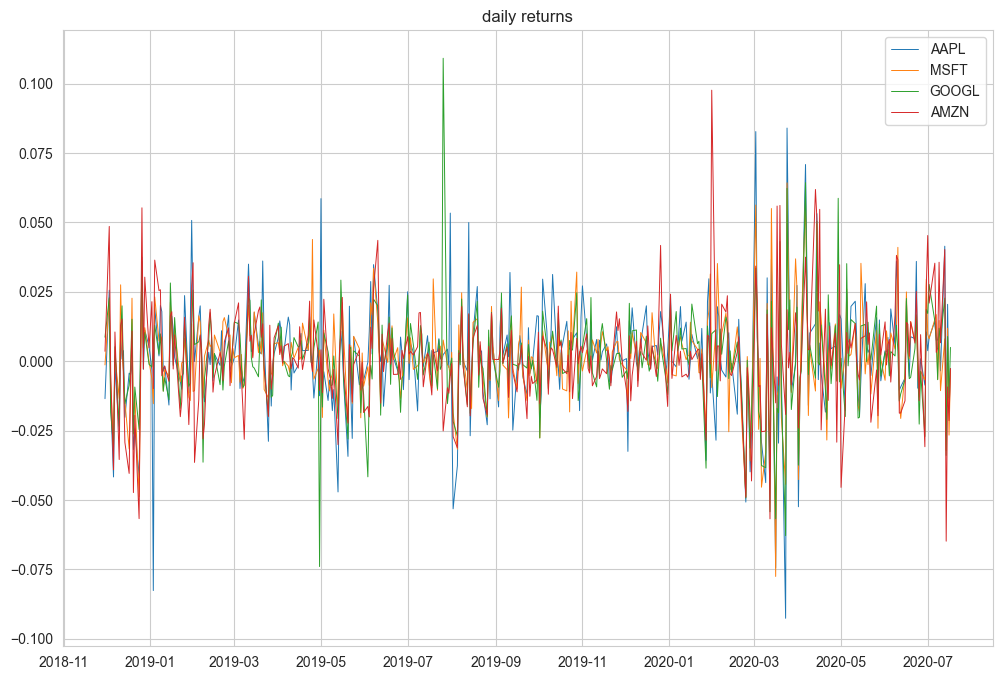

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
for k in range(4):
    plt.plot(dates[1:], data[k], label=companies[k], linewidth=0.7)
plt.title('daily returns')
plt.legend()
plt.show()

#### Sentiment probabilities

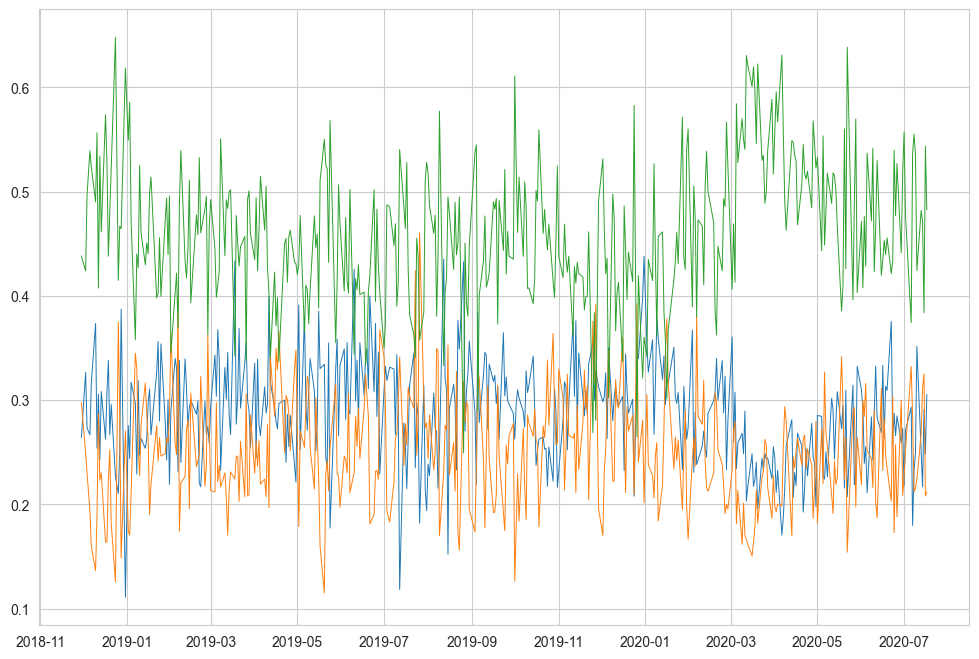

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
plt.plot(dates[1:], data[-1], linewidth=0.7)
plt.plot(dates[1:], data[-2], linewidth=0.7)
plt.plot(dates[1:], data[-3], linewidth=0.7)

### Multivariate Time Series Sequenced 

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

sequence_length = 50
data_sequenced = []

for i in range(len(data[0]) - sequence_length):
    data_sequenced.append(data[:, i:i+sequence_length])
data_sequenced = np.array(data_sequenced) # Shape : (num_sequences, num_series, timesteps=sequence_length-1)

X_scaled_sequenced = torch.tensor(data_sequenced, dtype=torch.float32)
X_tensors = X_scaled_sequenced[:, :, :-1]  # All but the last value as features
y_tensors = X_scaled_sequenced[:, :-3, -1]   # Last value as target, without the sentiment

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_tensors, y_tensors, test_size=0.2, random_state=42)

# Create DataLoader for batching
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

X_train shape : torch.Size([287, 203, 49])
y_train shape : torch.Size([287, 200])


## Models

### LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, intermediate_size=256, dropout=0.2):
        super(LSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(intermediate_size, intermediate_size)
        self.tanh = nn.Tanh()
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(intermediate_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states to zeros
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)  # Cell state
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer to produce the final output
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout2(out)
        out = self.fc3(out) # Shape: (batch_size, output_size)
        
        return out

## Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            path (str): Path to save the best model.
            verbose (bool): Print messages about early stopping.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save the model when validation loss improves."""
        if self.verbose:
            print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        torch.save(model.state_dict(), self.path)

## Training

### LSTM

In [ ]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Hyperparameters
hidden_size = 128
num_layers = 6
dropout = 0.1

learning_rate = 0.02
num_epochs = 200

# Initialize the LSTM model
model = LSTM(input_size, hidden_size, output_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=50, verbose=True)

### Training Loop

In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, input_size)
        y_batch = y_batch  # Shape: (batch_size, num_features)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, input_size)
            y_batch = y_batch  # Shape: (batch_size, num_features)
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"\nEpoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

    # Check early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("\n     ###################     \n Early stopping triggered \n     ###################     ")
        break


Epoch 1, Train Loss: 0.616524, Validation Loss: 0.009259
Validation loss decreased to 0.009259. Saving model...

Epoch 2, Train Loss: 0.004279, Validation Loss: 0.001786
Validation loss decreased to 0.001786. Saving model...

Epoch 3, Train Loss: 0.001306, Validation Loss: 0.000628
Validation loss decreased to 0.000628. Saving model...

Epoch 4, Train Loss: 0.000803, Validation Loss: 0.000394
Validation loss decreased to 0.000394. Saving model...

Epoch 5, Train Loss: 0.000683, Validation Loss: 0.000350
Validation loss decreased to 0.000350. Saving model...

Epoch 6, Train Loss: 0.000673, Validation Loss: 0.000368
EarlyStopping counter: 1 out of 50

Epoch 7, Train Loss: 0.000637, Validation Loss: 0.000351
EarlyStopping counter: 2 out of 50

Epoch 8, Train Loss: 0.000613, Validation Loss: 0.000346
Validation loss decreased to 0.000346. Saving model...

Epoch 9, Train Loss: 0.000603, Validation Loss: 0.000353
EarlyStopping counter: 1 out of 50

Epoch 10, Train Loss: 0.000587, Validation

## Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.permute(0, 2, 1)  # Add feature dimension
        y_batch = y_batch

        # Forward pass
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # Multiply by batch size to account for averaging

    # Calculate the average loss over the entire test set
    test_loss = total_loss / len(val_loader.dataset)
    print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.000407


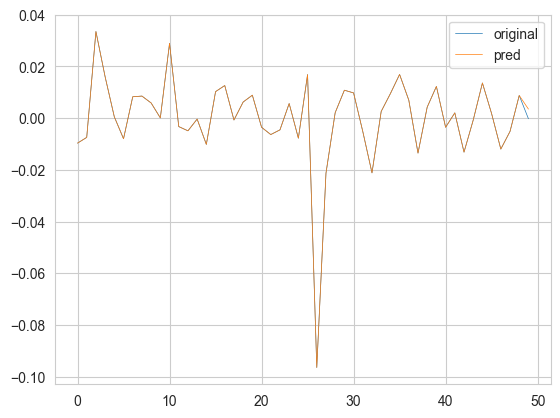

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly pick a sample from the validation set
i = np.random.randint(0, X_val.shape[0])
j = np.random.randint(0, X_val.shape[1])
with torch.no_grad():
    # Prepare input
    x = X_val[i].unsqueeze(0).permute(0, 2, 1)  # Shape: (1, sequence_length, input_size)
    y = y_val[i].unsqueeze(0)  # Shape: (1, num_features)

    # Predict
    y_pred = model(x)  # Shape: (1, num_features)

    # Convert tensors to NumPy arrays for processing
    x = x.squeeze(0).permute(1, 0).numpy()[:-3, :]  # Shape: (sequence_length, input_size)
    y = y.squeeze(0).numpy()  # Shape: (num_features,)
    y_pred = y_pred.squeeze(0).numpy()  # Shape: (num_features,)


    # Append the predicted and actual target values as the last "step" in the input sequence
    x_org = np.concatenate((x, y.reshape(-1, 1)), axis=1)[j]  # Append `y_resized` as the last step
    x_pred = np.concatenate((x, y_pred.reshape(-1, 1)), axis=1)[j]  # Append `y_pred_resized` as the last step
    # Extract the last 50 points for visualization
    x_org_last = x_org[-50:]
    x_pred_last = x_pred[-50:]

    # Plot the original and predicted sequences
    plt.plot(x_org_last, linewidth=0.5, label="original")  # Plot the last feature dimension
    plt.plot(x_pred_last, linewidth=0.5, label="pred")    # Plot the last feature dimension
    plt.legend()
    plt.show()